# Use Different Strategies to Select Points to Label
In this example, we will use `active_learning` to pick one batch of points to evaluate next

In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from sklearn.base import clone
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

import active_learning
from active_learning.utils import *
from active_learning.selectors import identity_selector
from active_learning.query_strats import random_sampling, uncertainty_sampling, active_search, greedy
from active_learning.query_strats.batch_active_search import seq_sim_batch

%matplotlib inline

Set the random seed for the experiment

In [2]:
np.random.seed(0)

## Make some Toy Data
Have a little binary classification task that is not linearly separable.

In [3]:
X, y = make_moons(noise=0.1, n_samples=200)

Turn it into a DataFrame

In [4]:
data = dict(zip(['x1', 'x2'], X.T.tolist()))
data['y'] = y
data = pd.DataFrame(data)

Pretend like most of the data is unlabeled

In [5]:
data['is_labeled'] = False
data.loc[175:, 'is_labeled'] = True

Plot it all

In [6]:
xlim = [-1.25, 2.2]
ylim = [-0.8, 1.3]

(-0.8, 1.3)

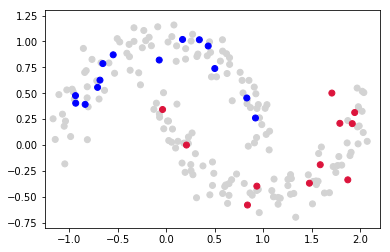

In [7]:
fig, ax = plt.subplots()

# We are going to be reusing this data a few times
data['color'] = data['y'].apply(lambda x: 'crimson' if x else 'blue')
    
ax.scatter(data['x1'], data['x2'],
           color=data[['color', 'is_labeled']].T.apply(lambda x: x['color'] if x['is_labeled'] else 'lightgray'))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

We have a few examples of each class, are going going to try more of the read ones

## Training Model
Train a basic SVC to use for use during the search procedure

In [8]:
# Our basic classifier will be a SVM with rbf kernel
base_clf = GaussianProcessClassifier(RBF(1.0))

In [9]:
labeled_subset = data.query('is_labeled == True')

In [10]:
base_clf.fit(labeled_subset[['x1', 'x2']], labeled_subset['y'])

GaussianProcessClassifier(copy_X_train=True, kernel=RBF(length_scale=1),
             max_iter_predict=100, multi_class='one_vs_rest', n_jobs=1,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=False)

Plot the decision surface

In [11]:
xx, yy = np.meshgrid(np.linspace(*xlim, 8), np.linspace(*ylim, 8))

In [12]:
prob = base_clf.predict_proba(list(zip(xx.flatten(), yy.flatten())))[:, 0].reshape(xx.shape, order='C')

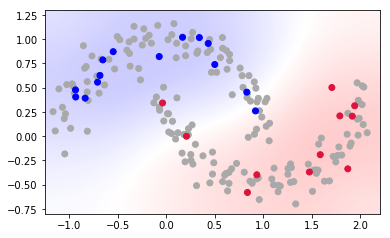

In [13]:
fig, ax = plt.subplots()

ax.imshow(prob, cmap='seismic_r', origin=(0,0), interpolation='bicubic', alpha=0.2,
         extent=xlim+ylim, vmin=0, vmax=1)

ax.scatter(data['x1'], data['x2'],
           color=data[['color', 'is_labeled']].T.apply(lambda x: x['color'] if x['is_labeled'] else 'darkgray'))

## Define the Active Learning Problem
`active_learning` uses a "problem definition" dictionary for all of the query stategies, which contains:
- `points`: an (n_samples, n_dim) matrix of all points in the problem space (labeled and unlabeled)
- `num_classes`: the number of different classes [0, num_classes)
- `batch_size`: number of points to query each iteration
- `num_queries`: the max number of queries we can make on the data [Not sure what this means]
- `model`: the scikit-learn model we are training

In [14]:
problem = {
    'points': data[['x1', 'x2']].values,
    'num_classes': 2,
    'batch_size': 8,
    'num_queries': len(data),
    'model': base_clf
}

We also need to provide the indices and labels for each point that has been measured

In [15]:
train_ixs = data.query('is_labeled').index.tolist()
obs_labels = data.loc[train_ixs, 'y'].tolist()
print('There are {} labeled points'.format(len(train_ixs)))

There are 25 labeled points


## Decide which Unlabelled Points are Worthwhile to Label
Not all potential points in the search space are worth considering for active search. Some could be very unlikely to be the target class, for example, others might be too costly. `active_learning` has a library of tools available for taking the space of observations and potential points to label, and identifying the the "worthwhile" space. For here, we assume all unlabeled points are valid.

In [16]:
unlabeled_ixs = identity_selector(problem, train_ixs, obs_labels)

## Run Different Querying Strategies
The main capability of `active_learning` is that it implements many strategies for how to select which points to label next. These are known as "querying strategies." In this section, we demonstrate using a few

### Random Sampling
Just pick points at random

In [17]:
%%time
random_ixs = random_sampling(problem, train_ixs, obs_labels, unlabeled_ixs, problem['batch_size'])

Wall time: 0 ns


### Greedy Sampling
Just pick the points most likely to be blue

In [18]:
%%time
greedy_ixs = greedy(problem, train_ixs, obs_labels, unlabeled_ixs, problem['batch_size'])

Wall time: 3 ms


### Uncertainty Sampling
Pick the points with the highest uncertainty in the ML model

In [19]:
%%time
uncertainty_ix = uncertainty_sampling(problem, train_ixs, obs_labels, unlabeled_ixs, problem['batch_size'])

Wall time: 0 ns


### Active Search
Active search is a more developed technique. It uses both the probably an entry will be a target class (here, we define the target class as `y == 1`), and the probability that - if labeled - a point will improve the model's ability to find new target classes.

In [20]:
%%time
active_ix = active_search(problem, train_ixs, obs_labels, unlabeled_ixs, problem['batch_size'], budget=2)

Wall time: 4.55 s


### Batch Active Search
Batch Active Search is different from regular active search in that it picks a group of points that collectively has the best  utility. This is more expensive, but prevents the algorithm from picking a homogeneous batch of points.

In [21]:
%%time
batch_active_ix = seq_sim_batch(problem, train_ixs, obs_labels, unlabeled_ixs, problem['batch_size'], budget=2)

Wall time: 40.5 s


## Compare the Selections
To demonstrate the effect of each labeling, we show the results of each pick

In [22]:
def plot_selection(ax, data, indices): 
    """Plot the selections of a certain query strategy
    
    Args:
        ax: Axis to plot on
        data: Data to plot
        indices: List of selected entries
    """

    # Plot the classifier
    ax.imshow(prob, cmap='seismic_r', origin=(0,0), interpolation='bicubic', alpha=0.35,
         extent=xlim+ylim, aspect='auto', vmin=0, vmax=1)
    
    # Plot the original data
    original_data = data[[x not in indices for x in data.index]]
    ax.scatter(original_data['x1'], original_data['x2'], label=None,
           color=original_data[['color', 'is_labeled']].T.apply(lambda x: x['color'] if x['is_labeled'] else 'darkgray'))
    
    # Plot the selections
    new_selections = data.loc[indices]
    ax.scatter(new_selections['x1'], new_selections['x2'], marker='x', color=new_selections['color'], label='Selected')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

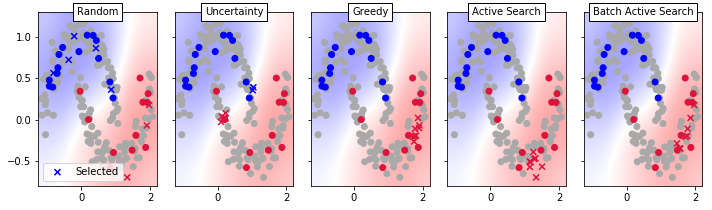

In [23]:
fig, axs = plt.subplots(1, 5, sharey=True)

plot_selection(axs[0], data, random_ixs)
plot_selection(axs[1], data, uncertainty_ix)
plot_selection(axs[2], data, greedy_ixs)
plot_selection(axs[3], data, active_ix)
plot_selection(axs[4], data, batch_active_ix)

for ax, t in zip(axs, ['Random', 'Uncertainty', 'Greedy', 'Active Search', 'Batch Active Search']):
    ax.text(0.5, 1, t, transform=ax.transAxes, ha='center', va='center',
             bbox={'facecolor': 'w', 'edgecolor': 'k'})

axs[0].legend()

fig.set_size_inches(10, 3)
fig.tight_layout()

Note that random picks points clos eto where the boundaries are. Uncertainty sampling picks points close where the classifier has a probability near 50%. Greedy picks points near farthest from the decision boundary. Regular active search picks points that are somewhere in between, but all clustered. Batch active search picks a larger diversity of points